In [23]:
import os
import pandas as pd
import openai
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
import tiktoken
import ast
import json
from langchain_core.output_parsers import JsonOutputParser
import concurrent.futures
import matplotlib.pyplot as plt

load_dotenv()
openai.api_key = os.environ['OPENAI_API_KEY']

In [24]:
excel_path = "data/tcfd第四層揭露指引.xlsx"
df_labels = pd.read_excel(excel_path).dropna(subset=['Label', 'Definition'])
label_mapping = dict(zip(df_labels['Label'], df_labels['Definition']))

In [25]:
label_mapping

{'G-1-1_1': '公司是否描述向董事會和/或董事會下設委員會，定期報告氣候相關風險與機會之流程？',
 'G-1-1_2': '公司是否描述向董事會和/或董事會下設委員會，報告氣候相關風險與機會之頻率？',
 'G-1-2_3': '公司是否描述董事會和/或董事會下設委員會，在監督和指導策略、重要行動計畫、風險管理政策、年度預算和營業計畫、公司的營業目標、計畫實施和執行情況時，考量氣候相關風險與機會？',
 'G-1-2_4': '公司是否描述董事會和/或董事會下設委員會，在監督重要資本支出、企業收購和撤資時，考量氣候相關風險與機會？',
 'G-1-3_5': '公司是否描述董事會或其所屬和/或指派之委員會如何監督風險與機會目標之實現？',
 'G-2-1_6': '公司是否描述已分派氣候相關責任給管理職位或委員會？',
 'G-2-1_7': '公司是否描述該管理職位或委員會向董事會或董事會下設委員會進行報告？',
 'G-2-1_8': '公司是否描述已分派之職責包含評估和/或管理氣候相關風險與機會？',
 'G-2-2_9': '公司是否有對氣候相關組織結構之描述？',
 'G-2-2_10': '公司是否描述有跨部門之氣候相關工作小組統籌執行相關工作？',
 'G-2-3_11': '公司是否描述執行管理階層掌握氣候相關風險與機會之流程？',
 'G-2-4_12': '公司是否提供管理階層透過特定職位監控氣候相關風險與機會之說明？',
 'G-2-4_13': '公司是否提供管理階層透過委員會監控氣候相關風險與機會之說明？',
 'S-1-1_14': '公司是否描述「短期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命？',
 'S-1-1_15': '公司是否描述「中期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及中期對公司與供應鏈潛在的氣候相關風險與機會？',
 'S-1-1_16': '公司是否描述「長期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及長期對公司與供應鏈潛在的氣候相關風險與機會？',
 'S-1-2_17': '公司應描述在「短期」的時間長度下，可能會產生重大財務影響的氣候相關風險與機會？',
 'S-1-2_18': '公司應描述在「中期」的時間長度下，可能會產生重大財務影響的氣候相

In [26]:
MODEL_NAME = "gpt-4o-mini"
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)

def query_llm_for_verification(chunk, matched_label_json):
    # Parse the matched_label_json to extract just the labels
    try:
        matched_labels = json.loads(matched_label_json)
        label_list = [item["label"] for item in matched_labels]
    except:
        label_list = []
        
    prompt = f"""
        ### 背景資訊 ###
        你是氣候相關財務揭露工作的專家，熟悉 Task Force on Climate-related Financial Disclosures(TCFD) 第四層揭露指引的標準與其詳細定義有深入的理解。你的任務是嚴謹地審閱提供的報告書內容，並判斷其中是否明確揭露了以下特定的 TCFD 標準。

        請根據以下報告書內容進行判斷：
        {chunk}

        請僅針對以下揭露標準及其**明確定義**進行評估。你的判斷必須**嚴格依據報告書內容**以及**每個標準所提供的定義**，不要評估或包含任何其他未列出的標準。
        {matched_labels}

        ### 回覆格式 ###
        請務必僅回覆純 JSON 格式，不要包含任何 Markdown 語法、程式碼區塊或額外說明文字。你的回覆必須是一個 JSON 陣列，其中每個物件對應一個你所評估的揭露標準。回覆中的 JSON 物件數量必須與你收到的揭露標準數量相同。每個 JSON 物件必須包含以下欄位：
        1. chunk: string，此判斷所依據的原始報告書內容片段。
        2. label: string，對應的揭露標準代碼。
        3. reason: string，請詳細說明你的判斷推理過程。
           - 若 `is_disclosed` 為 true (1)，請具體指出報告書中哪部分內容、如何符合該揭露標準的定義。
           - 若 `is_disclosed` 為 false (0)，請具體說明為何報告書中**未見相關揭露**，例如缺乏特定資訊或不符合定義要求。
        4. is_disclosed: boolean，若報告書中**明確且充分地**揭露了該標準的定義，則回覆 1 (true)；若**未明確揭露**或內容不符合定義，則回覆 0 (false)。

        請你針對以下所有標準逐一進行評估，並在 JSON 陣列中提供對應的結果：
        [{', '.join([f'/"{lb}/"' for lb in label_list])}]
    """

    try:
        response = openai.chat.completions.create(
            model=MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error querying LLM: {e}")
        return "Error"


In [27]:
similarity_matched_dir = "data/tcfd_report_pdf_chunks_matching_result_第四層/"
chunk_csv_files = [os.path.join(similarity_matched_dir, f) for f in os.listdir(similarity_matched_dir) if f.endswith('.csv')]
df_chunks_all = pd.concat([pd.read_csv(file) for file in chunk_csv_files], ignore_index=True)

In [28]:
df_chunks_all

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List
0,臺灣銀行_2022.pdf,0,1\n氣候治理\n1.1\t 董事會對氣候相關風險與機會的監督情況\n1.2\t 管理階層評...,"[-0.001920376205816865, -0.032715845853090286,...","['G-1-2_3', 'G-2-4_13', 'G-1-1_1', 'G-2-4_12',...","[0.20337061047950544, 0.20434908745016628, 0.2..."
1,臺灣銀行_2022.pdf,1,臺銀由董事會負責監督及審核氣候風險相關政策及管理，2022 年度董事會\n亦對環境保護（En...,"[-0.006571792531758547, -0.03631797060370445, ...","['G-1-2_3', 'G-1-1_1', 'G-1-3_5', 'G-1-1_2', '...","[0.21670393183882658, 0.24871880490200024, 0.2..."
2,臺灣銀行_2022.pdf,2,檢討，每年向董事會或常務董事會報告永續發展實施成效（包含氣候\n變遷議題，最近一年報告的時間...,"[-0.014258412644267082, -0.029878512024879456,...","['G-1-1_1', 'G-1-2_3', 'G-1-1_2', 'G-2-4_13', ...","[0.2181578811305123, 0.2224353694520268, 0.232..."
3,臺灣銀行_2022.pdf,3,6 未來展望\n5 指標與目標\n7 附錄\n5\n氣\n候\n相\n關\n財\n務\n揭\...,"[-0.006627093534916639, -0.03144928440451622, ...","['#MT-1-6_#MT1', 'G-1-2_3', 'G-1-1_1', 'G-2-4_...","[0.20432150188340314, 0.244177150487337, 0.248..."
4,臺灣銀行_2022.pdf,4,關工作。臺銀於企業永續發展委員會下，責成「環境永續小組」、\n「責任金融小組」執行氣候變遷相...,"[-0.005565736908465624, -0.03625981882214546, ...","['#MT-1-6_#MT1', 'G-1-2_3', 'G-1-1_1', 'R-2-1_...","[0.2518456217070147, 0.2576224959987099, 0.259..."
...,...,...,...,...,...,...
115,臺灣銀行_2022.pdf,115,財務部、其他責任金融小組相關單位共同推動，其短、中、長期目標如下：\n註5：111 年度臺銀...,"[-0.011882993392646313, -0.0392436683177948, 0...","['#MT-1-6_#MT1', '#MT-1-7_#MT2', '#MT-2-4_#MT5...","[0.2516078238655052, 0.2578600584526963, 0.279..."
116,臺灣銀行_2022.pdf,116,引導客戶制定淨零方案並加速永續轉型。\n3. 持續透過PCAF 標準並依據SBTi 方法學設...,"[-0.017274044454097748, -0.03989029675722122, ...","['#MT-1-6_#MT1', 'S-2-6_37', '#MT-2-4_#MT5', '...","[0.2330020869951796, 0.25428578956197606, 0.25..."
117,臺灣銀行_2022.pdf,117,前言\n董事長的話\n2 氣候風險管理\n1 氣候治理\n3 氣候風險與機會\n4 氣氣候風...,"[-0.017422141507267952, -0.036069173365831375,...","['S-1-2_18', 'G-1-2_3', 'S-1-2_19', 'S-1-2_17'...","[0.23054658494665217, 0.23287180280165615, 0.2..."
118,臺灣銀行_2022.pdf,118,大化環境影響力，誠信揭露其與氣候變遷風險與機會。面對低碳轉型的浪潮，臺銀做為臺灣產業推手及肩...,"[-0.006739138625562191, -0.04679350554943085, ...","['#MT-1-6_#MT1', '#S-1-5_#S2', '#R-1-5_#R2', '...","[0.20304000941633404, 0.23062318249858405, 0.2..."


In [29]:
# 定義一個函式來轉換欄位值，如果已經是 list 就直接返回
def convert_to_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception as e:
            print("轉換錯誤：", e)
            return []
    else:
        return []

all_labels_lists = df_chunks_all['Matched_Categories_List'].apply(convert_to_list)

# 將所有列表攤平成一個大列表
unique_labels = set()
for labels in all_labels_lists:
    unique_labels.update(labels)

print("所有欄位的 Matched_Categories 中共有", len(unique_labels), "個 unique 的 label")
print("Unique labels:", unique_labels)

所有欄位的 Matched_Categories 中共有 91 個 unique 的 label
Unique labels: {'S-2-6_37', 'MT-1-1_59', 'MT-1-1_58', 'R-2-2_53', 'S-1-1_15', 'R-3-2_56', 'S-3-1_38', 'R-1-1_46', 'G-2-2_10', 'MT-1-3_62', 'S-1-1_14', 'S-1-4_21', 'G-1-3_5', 'MT-1-3_63', 'G-2-4_13', 'S-2-6_36', 'S-1-2_17', '#R-1-5_#R2', 'S-2-2_28', 'S-2-1_24', 'S-3-3_44', 'MT-2-2_70', 'S-2-4_34', 'MT-2-1_69', 'MT-1-1_57', 'R-1-1_47', 'S-2-1_23', 'G-1-1_2', 'G-1-2_4', 'MT-1-5_66', 'G-2-4_12', 'R-1-3_50', 'MT-2-1_68', 'S-3-1_39', 'G-1-2_3', 'S-3-2_42', 'S-1-4_22', 'MT-1-2_61', 'S-3-2_41', '#MT-2-4_#MT5', 'S-2-2_31', 'G-2-1_6', 'MT-2-3_73', 'MT-3-1_75', 'S-2-2_30', 'S-2-3_32', 'MT-3-3_81', 'R-1-2_48', '#R-1-4_#R1', 'MT-3-1_74', 'MT-2-3_71', 'MT-1-4_64', 'R-2-1_51', 'S-2-1_27', 'G-2-3_11', '#MT-1-7_#MT2', 'S-2-1_25', 'S-2-1_26', 'MT-2-1_67', '#MT-1-8_#MT4', 'S-3-2_40', 'MT-1-2_60', 'S-3-2_43', '#S-1-5_#S2', 'MT-2-3_72', 'G-2-2_9', 'R-3-1_55', 'MT-3-2_76', 'S-1-2_19', 'G-1-1_1', 'S-1-2_18', 'G-2-1_8', 'G-2-1_7', 'MT-1-4_65', 'MT-3-2_78', 'S-2

In [30]:
def transform_matched_categories(val):
    # 若欄位為空值，則回傳空清單的JSON字串
    if pd.isnull(val):
        return json.dumps([])
    try:
        label_list = ast.literal_eval(val) if isinstance(val, str) else val
    except Exception as e:
        label_list = []
    
    json_list = []
    for label in label_list:
        json_list.append({
            "label": label,
            "label_definition": label_mapping.get(label, "")
        })
    return json.dumps(json_list, ensure_ascii=False)

In [31]:
df_chunks_all['Matched_Categories'] = df_chunks_all['Matched_Categories_List'].apply(transform_matched_categories)

df_chunks_all.head()

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List,Matched_Categories
0,臺灣銀行_2022.pdf,0,1\n氣候治理\n1.1\t 董事會對氣候相關風險與機會的監督情況\n1.2\t 管理階層評...,"[-0.001920376205816865, -0.032715845853090286,...","['G-1-2_3', 'G-2-4_13', 'G-1-1_1', 'G-2-4_12',...","[0.20337061047950544, 0.20434908745016628, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是..."
1,臺灣銀行_2022.pdf,1,臺銀由董事會負責監督及審核氣候風險相關政策及管理，2022 年度董事會\n亦對環境保護（En...,"[-0.006571792531758547, -0.03631797060370445, ...","['G-1-2_3', 'G-1-1_1', 'G-1-3_5', 'G-1-1_2', '...","[0.21670393183882658, 0.24871880490200024, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是..."
2,臺灣銀行_2022.pdf,2,檢討，每年向董事會或常務董事會報告永續發展實施成效（包含氣候\n變遷議題，最近一年報告的時間...,"[-0.014258412644267082, -0.029878512024879456,...","['G-1-1_1', 'G-1-2_3', 'G-1-1_2', 'G-2-4_13', ...","[0.2181578811305123, 0.2224353694520268, 0.232...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是..."
3,臺灣銀行_2022.pdf,3,6 未來展望\n5 指標與目標\n7 附錄\n5\n氣\n候\n相\n關\n財\n務\n揭\...,"[-0.006627093534916639, -0.03144928440451622, ...","['#MT-1-6_#MT1', 'G-1-2_3', 'G-1-1_1', 'G-2-4_...","[0.20432150188340314, 0.244177150487337, 0.248...","[{""label"": ""#MT-1-6_#MT1"", ""label_definition"":..."
4,臺灣銀行_2022.pdf,4,關工作。臺銀於企業永續發展委員會下，責成「環境永續小組」、\n「責任金融小組」執行氣候變遷相...,"[-0.005565736908465624, -0.03625981882214546, ...","['#MT-1-6_#MT1', 'G-1-2_3', 'G-1-1_1', 'R-2-1_...","[0.2518456217070147, 0.2576224959987099, 0.259...","[{""label"": ""#MT-1-6_#MT1"", ""label_definition"":..."


In [32]:
json_parser = JsonOutputParser()
format_instructions = json_parser.get_format_instructions()
print(format_instructions)

Return a JSON object.


In [33]:
def process_row(index, row):
    chunk_text = row['Chunk_Text']
    matched_categories_json = row['Matched_Categories']
    print(f"處理第 {index} 筆資料...")
    
    response = json_parser.invoke(query_llm_for_verification(chunk_text, matched_categories_json))
    
    return index, response

In [34]:
results = {}

with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    future_to_index = {executor.submit(process_row, index, row): index for index, row in df_chunks_all.iterrows()}
    for future in concurrent.futures.as_completed(future_to_index):
        index = future_to_index[future]
        try:
            idx, response = future.result()
            results[idx] = response
        except Exception as exc:
            print(f"第 {index} 筆資料處理發生異常: {exc}")
            results[index] = "Error"

df_chunks_all['LLM_Response'] = df_chunks_all.index.map(results.get)

df_chunks_all[['Chunk_Text', 'Matched_Categories', 'LLM_Response']].head()

處理第 0 筆資料...
處理第 1 筆資料...
處理第 2 筆資料...
處理第 3 筆資料...
處理第 4 筆資料...
處理第 5 筆資料...
處理第 6 筆資料...
處理第 7 筆資料...
處理第 8 筆資料...
處理第 9 筆資料...
處理第 10 筆資料...
處理第 11 筆資料...
處理第 12 筆資料...
處理第 13 筆資料...
處理第 14 筆資料...
處理第 15 筆資料...
處理第 16 筆資料...
處理第 17 筆資料...
處理第 18 筆資料...
處理第 19 筆資料...
處理第 20 筆資料...
處理第 21 筆資料...
處理第 22 筆資料...
處理第 23 筆資料...
處理第 24 筆資料...
處理第 25 筆資料...
處理第 26 筆資料...
處理第 27 筆資料...
處理第 28 筆資料...
處理第 29 筆資料...
處理第 30 筆資料...
處理第 31 筆資料...
處理第 32 筆資料...
處理第 33 筆資料...
處理第 34 筆資料...
處理第 35 筆資料...
處理第 36 筆資料...
處理第 37 筆資料...
處理第 38 筆資料...
處理第 39 筆資料...
處理第 40 筆資料...
處理第 41 筆資料...
處理第 42 筆資料...
處理第 43 筆資料...
處理第 44 筆資料...
處理第 45 筆資料...
處理第 46 筆資料...
處理第 47 筆資料...
處理第 48 筆資料...
處理第 49 筆資料...
處理第 50 筆資料...
處理第 51 筆資料...
處理第 52 筆資料...
處理第 53 筆資料...
處理第 54 筆資料...
處理第 55 筆資料...
處理第 56 筆資料...
處理第 57 筆資料...
處理第 58 筆資料...
處理第 59 筆資料...
處理第 60 筆資料...
處理第 61 筆資料...
處理第 62 筆資料...
處理第 63 筆資料...
處理第 64 筆資料...
處理第 65 筆資料...
處理第 66 筆資料...
處理第 67 筆資料...
處理第 68 筆資料...
處理第 69 筆資料...
處理第 70 筆資料...
處理第 71 筆資料...
處理

,Chunk_Text,Matched_Categories,LLM_Response
0,1\n氣候治理\n1.1\t 董事會對氣候相關風險與機會的監督情況\n1.2\t 管理階層評...,"[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...",[{'chunk': '臺銀由董事會負責監督及審核氣候風險相關政策及管理，2022 年度董事...
1,臺銀由董事會負責監督及審核氣候風險相關政策及管理，2022 年度董事會\n亦對環境保護（En...,"[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...",[{'chunk': '董事會亦對環境保護（Environment；E）、社會責任（Soci...
2,檢討，每年向董事會或常務董事會報告永續發展實施成效（包含氣候\n變遷議題，最近一年報告的時間...,"[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是...",[{'chunk': '檢討，每年向董事會或常務董事會報告永續發展實施成效（包含氣候變遷議題...
3,6 未來展望\n5 指標與目標\n7 附錄\n5\n氣\n候\n相\n關\n財\n務\n揭\...,"[{""label"": ""#MT-1-6_#MT1"", ""label_definition"":...",[{'chunk': '氣候相關財務揭露TCFD報告書 Task Force on Clim...
4,關工作。臺銀於企業永續發展委員會下，責成「環境永續小組」、\n「責任金融小組」執行氣候變遷相...,"[{""label"": ""#MT-1-6_#MT1"", ""label_definition"":...","[{'chunk': '1. 將氣候變遷風險議題納入風險管理機制', 'label': '#..."


In [35]:
def analyze_llm_responses(df):
    all_original_labels = set()
    all_llm_found_labels = set()
    
    for _, row in df.iterrows():
        try:
            # Get original matched categories
            original_matched = json.loads(row['Matched_Categories'])
            original_labels = {item['label'] for item in original_matched}
            all_original_labels.update(original_labels)
            
            # Get LLM identified labels
            llm_response = json.loads(row['LLM_Response'])
            llm_labels = {item['label'] for item in llm_response}
            all_llm_found_labels.update(llm_labels)
            
        except Exception as e:
            continue
    
    # Labels found by LLM but not in original matches
    new_labels = all_llm_found_labels - all_original_labels
    
    print(f"Original matched labels: {len(all_original_labels)}")
    print(f"Labels identified by LLM: {len(all_llm_found_labels)}")
    print(f"New labels found by LLM: {len(new_labels)}")
    print(new_labels)
    
    return new_labels

In [36]:
df_chunks_all.to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv", index=False, encoding='utf-8')

In [14]:
verified_df = pd.read_csv('data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv')

# verified_df.head(20).to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_shorter.csv", index=False, encoding='utf-8')

In [15]:
verified_df.head()

,Filename,Chunk_ID,Chunk_Text,Embedding,Matched_Categories,Cosine_Distance,LLM_Response
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[0.11002939194440842, 0.11207939684391022, 0.1...",[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 \n\n-4-\n1 ...
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是...","[0.06464864313602448, 0.07524003833532333, 0.0...",[{'chunk': '會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、...
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.011314043775200844, -0.021306172013282776,...","[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...","[0.101962149143219, 0.10234063118696213, 0.102...",[{'chunk': '檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標...
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是...","[0.08129584789276123, 0.08162105828523636, 0.0...",[{'chunk': '-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組...
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...","[0.09030324220657349, 0.10328415036201477, 0.1...",[{'chunk': '措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議...


In [16]:
# df = pd.read_csv('data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_shorter.csv')
def parse_llm_response(response_str):
    try:
        return ast.literal_eval(response_str)
    except Exception as e:
        print(f"解析失敗: {e}, 原始字串: {response_str}")
        return []

verified_df['llm_list'] = verified_df['LLM_Response'].apply(parse_llm_response)


解析失敗: malformed node or string on line 1: <ast.Name object at 0x000002029CD12680>, 原始字串: Error
解析失敗: malformed node or string on line 1: <ast.Name object at 0x000002029CD10190>, 原始字串: Error
解析失敗: malformed node or string on line 1: <ast.Name object at 0x000002029CCD0F70>, 原始字串: Error
解析失敗: malformed node or string on line 1: <ast.Name object at 0x000002029CE6AA70>, 原始字串: Error


In [17]:
verified_df.head(2)

,Filename,Chunk_ID,Chunk_Text,Embedding,Matched_Categories,Cosine_Distance,LLM_Response,llm_list
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[0.11002939194440842, 0.11207939684391022, 0.1...",[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 \n\n-4-\n1 ...,[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 -4- 1 治理...
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是...","[0.06464864313602448, 0.07524003833532333, 0.0...",[{'chunk': '會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、...,[{'chunk': '會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、...


In [18]:
verified_df_exploded = verified_df.explode('llm_list')

In [19]:
verified_df_exploded.head(2)

,Filename,Chunk_ID,Chunk_Text,Embedding,Matched_Categories,Cosine_Distance,LLM_Response,llm_list
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[0.11002939194440842, 0.11207939684391022, 0.1...",[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 \n\n-4-\n1 ...,{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 -4- 1 治理 ...
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[0.11002939194440842, 0.11207939684391022, 0.1...",[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 \n\n-4-\n1 ...,{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 -4- 1 治理 ...


In [20]:
verified_df_exploded['Label'] = verified_df_exploded['llm_list'].apply(lambda x: x.get('label') if isinstance(x, dict) else None)
verified_df_exploded['LLM_Response'] = verified_df_exploded['llm_list'].apply(lambda x: x.get('is_disclosed', 0) if isinstance(x, dict) else 0)

verified_df_final = verified_df_exploded[['Filename', 'Chunk_ID', 'Label', 'LLM_Response']]
verified_df_final

,Filename,Chunk_ID,Label,LLM_Response
0,上海商銀_2022.pdf,0,G-2-1_8,1
0,上海商銀_2022.pdf,0,G-1-3_5,0
1,上海商銀_2022.pdf,1,G-1-1_1,1
1,上海商銀_2022.pdf,1,G-1-2_3,0
1,上海商銀_2022.pdf,1,G-1-2_4,0
...,...,...,...,...
977,元大金控_2022.pdf,197,S-3-2_41,1
977,元大金控_2022.pdf,197,S-2-1_27,1
977,元大金控_2022.pdf,197,S-3-2_42,0
978,元大金控_2022.pdf,198,G-2-1_8,1


In [21]:
unique_label_count = verified_df_final["Label"].nunique()
print("Unique labels count:", unique_label_count)

Unique labels count: 112


In [22]:
def extract_institution(filename):
    base = filename.split('.')[0]
    institution = base.split('_')[0]
    return institution

def extract_year(filename):
    base = filename.split('.')[0]
    parts = base.split('_')
    if len(parts) > 1:
        return parts[1]
    else:
        return None

def transform_label(label):
    if label is None:
        return None
    if '_' in label:
        return label.split('_')[-1]
    return label

def transform_response(response):
    if response == 1 or response == 1.0:
        return "Yes"
    elif response == 0 or response == 0.0:
        return "No"
    else:
        return response

In [23]:
df_transformed = verified_df_final.copy()

df_transformed['Institution'] = df_transformed['Filename'].apply(extract_institution)
df_transformed['Year'] = df_transformed['Filename'].apply(extract_year)

df_transformed['Label'] = df_transformed['Label'].apply(transform_label)

df_transformed['LLM_Response'] = df_transformed['LLM_Response'].apply(transform_response)

df_final = df_transformed[['Institution', 'Year', 'Label', 'LLM_Response']]

In [24]:
df_final["Label"].nunique()

89

In [25]:
df_final.head()

,Institution,Year,Label,LLM_Response
0,上海商銀,2022,8,Yes
0,上海商銀,2022,5,No
1,上海商銀,2022,1,Yes
1,上海商銀,2022,3,No
1,上海商銀,2022,4,No


In [27]:
answer_file_path = "data/answer/rank.xlsx"
answer_df = pd.read_excel(answer_file_path)

answer_df.head(5)

,Symbol,Financial_Institutions,Format,Year,1,2,3,4,5,6,...,R_2,R_3,MT_1,MT_2,MT_3,G,S,R,MT,Disclosure
0,2881,富邦金,1.0,2022,Y,Y,Y,Y,Y,Y,...,0.833333,1.0,0.833333,1.000000,1.00,0.937500,0.972222,0.911111,0.944444,0.941319
1,5880,合庫金,1.0,2022,Y,Y,Y,Y,Y,Y,...,1.000000,1.0,0.541667,1.000000,1.00,1.000000,0.913889,1.000000,0.847222,0.940278
2,5849,永豐銀行,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,1.0,0.645833,0.888889,1.00,0.854167,0.975000,0.866667,0.844907,0.885185
3,2891,中信金,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,0.5,0.645833,0.888889,0.75,0.916667,0.972222,0.833333,0.761574,0.870949
4,2884,玉山金,1.0,2022,Y,Y,Y,N,Y,Y,...,0.833333,1.0,0.625000,1.000000,0.75,0.916667,0.813889,0.944444,0.791667,0.866667


In [31]:
df_pivot = df_final.pivot_table(index=['Institution', 'Year'], columns='Label', values='LLM_Response', aggfunc='first')
df_pivot.reset_index(inplace=True)
# df_pivot.columns.name = None  # 移除 columns 名稱
# df_pivot.rename(columns={'Institution': 'Financial_Institutions'}, inplace=True)
# df_pivot.fillna("No", inplace=True)
df_pivot.head(5).to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_pivot.csv", index=False, encoding='utf-8')

In [32]:
df_pivot

Label,Institution,Year,#MT-4,#MT1,#MT2,#MT3,#MT4,#MT5,#R1,#R2,...,76,77,78,79,8,80,81,82,9,99
0,上海商銀,2022,NaN,No,No,NaN,Yes,No,Yes,No,...,No,Yes,No,No,Yes,No,No,NaN,NaN,NaN
1,中信金控,2021,NaN,No,NaN,NaN,NaN,NaN,Yes,No,...,NaN,No,NaN,No,Yes,No,No,NaN,Yes,NaN
2,中信金控,2022,NaN,No,No,No,Yes,No,No,No,...,No,No,No,No,Yes,No,No,No,No,NaN
3,中信銀行,2022,Yes,No,No,No,No,Yes,No,Yes,...,No,No,Yes,No,Yes,No,No,No,NaN,Yes
4,中輸銀行,2022,NaN,Yes,NaN,NaN,Yes,NaN,No,No,...,No,Yes,Yes,No,Yes,NaN,No,NaN,No,NaN
5,元大金控,2021,NaN,No,No,NaN,No,Yes,NaN,No,...,No,No,No,No,Yes,No,No,No,No,NaN
6,元大金控,2022,NaN,No,No,No,No,No,No,No,...,No,No,No,No,Yes,No,No,No,No,NaN


In [ ]:
# df_pivot.head(5).to_csv("tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_pivot_shorter.csv", index=False, encoding='utf-8')

In [37]:
df_pivot.columns = df_pivot.columns.astype(str)
answer_df.columns = answer_df.columns.astype(str)

answer_lookup = {}
for idx, row in answer_df.iterrows():
    key = (str(row['Financial_Institutions']), str(row['Year']))
    answer_lookup[key] = row
id_cols = ['Financial_Institutions', 'Year']

answer_cols_str = [str(x) for x in answer_df.columns]
common_columns = [str(col) for col in df_pivot.columns 
                  if str(col) not in id_cols and str(col) in answer_cols_str]

print("共同比對的欄位：", common_columns)
print(len(common_columns))
correct_count = 0
total_count = 0

inst_results = {}  # 格式：{ institution: {'correct': ..., 'total': ...}, ... }

inst_errors = {}   # 格式：{ institution: [ { 'Year': ..., 'Question': ..., 'Pivot Answer': ..., 'Correct Answer': ... }, ... ] }


for idx, pivot_row in df_pivot.iterrows():
    print(pivot_row)
    institution = str(pivot_row['Institution'])
    if institution[2:4] == "金控":
        institution = institution[0:2] + "金"

    key = (institution, str(pivot_row['Year']))
    if key not in answer_lookup:
        print(f"注意：找不到 {key} 對應於 answer_df 中的資料，跳過 df_pivot 第 {idx} 列。")
        continue
    answer_row = answer_lookup[key]
    print(answer_row)

    if institution not in inst_results:
        inst_results[institution] = {'correct': 0, 'total': 0}
    if institution not in inst_errors:
        inst_errors[institution] = []

    for col in common_columns:
        pivot_val = pivot_row[col]
        if pivot_val == "Yes":
            pivot_mapped = "Y"
        elif pivot_val == "No":
            pivot_mapped = "N"
        else:
            continue

        answer_val = str(answer_row[col])
        if pd.isna(answer_row[col]) or answer_val.lower() == 'nan':
            continue
        
        total_count += 1
        inst_results[institution]['total'] += 1
        
        if pivot_mapped == answer_val:
            correct_count += 1
            inst_results[institution]['correct'] += 1
        else:
            inst_errors[institution].append({
                'Year': pivot_row['Year'],
                'Question': col,
                'Pivot Answer': pivot_mapped,
                'Correct Answer': answer_val
            })

共同比對的欄位： ['#MT1', '#MT2', '#MT3', '#MT4', '#MT5', '#R1', '#R2', '#S1', '#S2', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '67', '68', '69', '7', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '9']
87
Label
Institution    上海商銀
Year           2022
#MT-4           NaN
#MT1             No
#MT2             No
               ... 
80               No
81               No
82              NaN
9               NaN
99              NaN
Name: 0, Length: 91, dtype: object
Symbol                        5876
Financial_Institutions        上海商銀
Format                         1.0
Year                          2022
1                                Y
                        

In [38]:
accuracy = correct_count / total_count if total_count > 0 else np.nan

print("總比對題數：", total_count)
print("正確題數：", correct_count)
print("全體準確率：", accuracy)

總比對題數： 507
正確題數： 194
全體準確率： 0.3826429980276134


In [39]:
print("各家Institution的準確率：")
for inst, counts in inst_results.items():
    inst_accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else np.nan
    print(f"{inst}: {inst_accuracy}")

各家Institution的準確率：
上海商銀: 0.4177215189873418
中信金: 0.3007518796992481
中信銀行: 0.5866666666666667
中輸銀行: 0.543859649122807
元大金: 0.2822085889570552


In [ ]:
print("每家 institution 答錯的題目明細：")
for inst, errors in inst_errors.items():
    if errors:
        print(f"\nInstitution: {inst} Year: {errors[0]['Year']}")
        for err in errors:
            print(f" Question: {err['Question']},  Pivot Answer: {err['Pivot Answer']},  Correct Answer: {err['Correct Answer']}")
    else:
        print(f"\nInstitution: {inst} 沒有答錯的題目。")

每家 institution 答錯的題目明細：

Institution: 上海商銀 Year: 2022
 Question: #MT1,  Pivot Answer: N,  Correct Answer: Y
 Question: #R2,  Pivot Answer: Y,  Correct Answer: N
 Question: #S1,  Pivot Answer: N,  Correct Answer: Y
 Question: #S2,  Pivot Answer: N,  Correct Answer: Y
 Question: 1,  Pivot Answer: N,  Correct Answer: Y
 Question: 10,  Pivot Answer: N,  Correct Answer: Y
 Question: 14,  Pivot Answer: N,  Correct Answer: Y
 Question: 15,  Pivot Answer: N,  Correct Answer: Y
 Question: 18,  Pivot Answer: N,  Correct Answer: Y
 Question: 2,  Pivot Answer: N,  Correct Answer: Y
 Question: 21,  Pivot Answer: N,  Correct Answer: Y
 Question: 23,  Pivot Answer: N,  Correct Answer: Y
 Question: 24,  Pivot Answer: N,  Correct Answer: Y
 Question: 25,  Pivot Answer: N,  Correct Answer: Y
 Question: 32,  Pivot Answer: N,  Correct Answer: Y
 Question: 36,  Pivot Answer: N,  Correct Answer: Y
 Question: 37,  Pivot Answer: N,  Correct Answer: Y
 Question: 38,  Pivot Answer: N,  Correct Answer: Y
 Questi

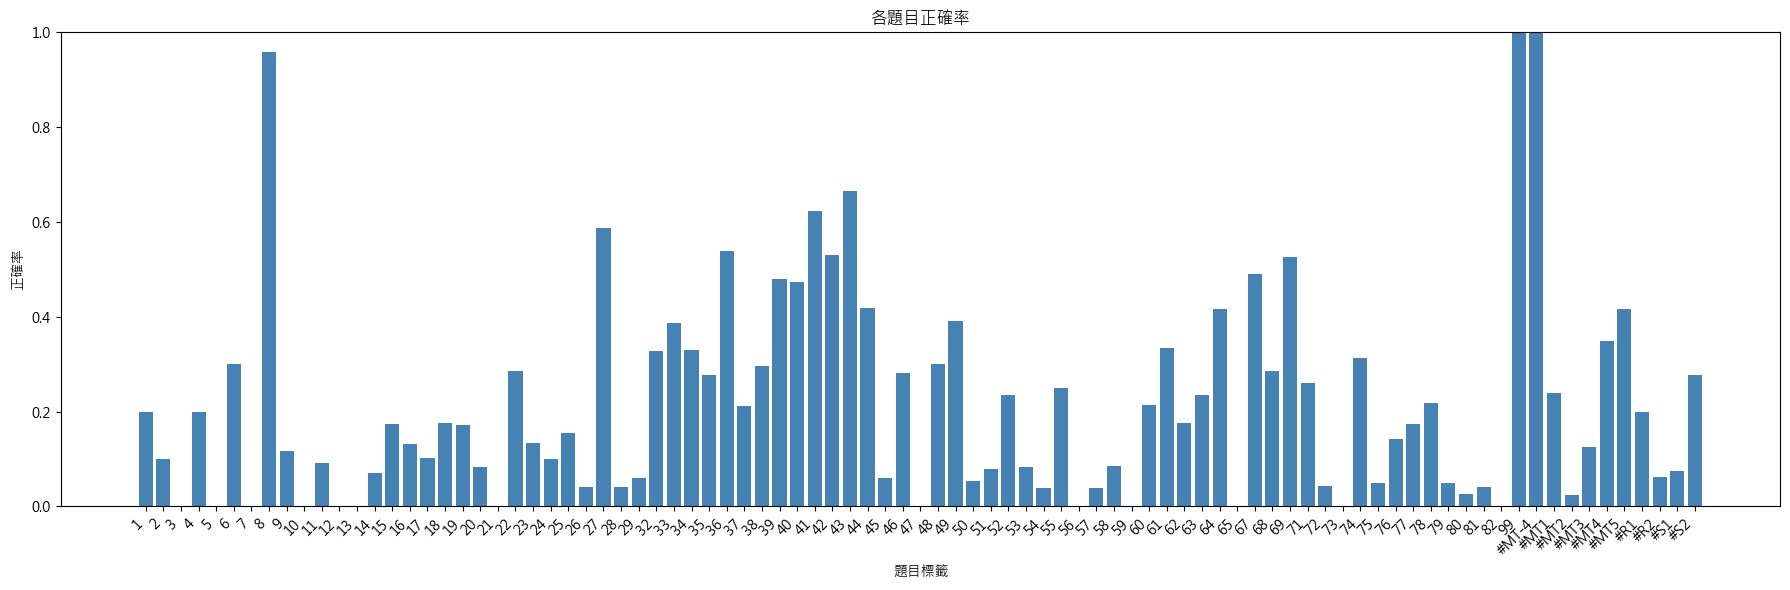

In [40]:
df_correctness = (
    df_final.groupby("Label")["LLM_Response"]
    .apply(lambda x: (x == "Yes").sum() / len(x))
    .reset_index(name="Accuracy")
)

def is_numeric(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

df_correctness["is_numeric"] = df_correctness["Label"].apply(is_numeric)

df_numeric = df_correctness[df_correctness["is_numeric"]].copy()
df_numeric["Label_numeric"] = df_numeric["Label"].astype(float)
df_numeric.sort_values("Label_numeric", inplace=True)

df_text = df_correctness[~df_correctness["is_numeric"]].copy()

df_final_sorted = pd.concat([df_numeric, df_text])

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(18, 6))
plt.bar(df_final_sorted["Label"], df_final_sorted["Accuracy"], color='steelblue')
plt.xlabel("題目標籤")
plt.ylabel("正確率")
plt.title("各題目正確率")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()